# Detecting Robots among Humans

## Group Name: LGTM

## Student Names

- Maxine Liu
- Roja Immanni
- Zachary Barnes

# Ask

Which classification algorithm can learn to best predict Robots among Humans?

# Acquire

The data is obtained from here: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot

### Load the required libraries

In [1]:
# for Data Manipulations
import pandas as pd
import numpy as np

# For modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, \
roc_auc_score, f1_score
import imblearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, Imputer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, KFold
from rfpimp import *
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# For plotting
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Load the datasets

In [2]:
%%time
logs = pd.read_csv('https://facebookbids.s3.us-east-2.amazonaws.com/bids.csv')
users = pd.read_csv('https://raw.githubusercontent.com/zs-barnes/Robot_or_not/master/data/train.csv',
                    error_bad_lines=False)

CPU times: user 15.8 s, sys: 5.75 s, total: 21.5 s
Wall time: 6min 45s


# Process

### Feature Hypothesis

As there are no direct features derived for the data, we came up with a list of features based on the problem context. 

Following is the list:

- Total Bid count
- Total Auctions
- Average bids per auction
- Average time-gap between bids per auction
- Minimum time-gap between bids per auction
- Merchandise Type
- Unique devices
- Avergae bids per Device
- Average bids per Country
- Avergae bids per IP
- Average bids per URL
- Unique countries
- Unique Ips
- Distinct Ips per auction
- Distinct Countries per auction
- Distinct Devices per auction

### Extract the feature hypothesis from the logs data

In [3]:
def prepare_data(data):
    
    """
    Returns the data by extracting required features from the corresponding logs data
    
    Input: Users data for which the features need to be extracted from the logs data
    output: Users data with important features
    """
    
    data = pd.merge(data, logs, on='bidder_id', how='left')
    
    
    # Derive categorical features based on whether a user ever bid for certain categories
    data.loc[(data.merchandise.isin(['auto parts','clothing','furniture'])),'merchandise_flag'] =1
    data['merchandise_flag'].fillna(0, inplace=True)
    
    data = data.groupby(['bidder_id','outcome']).agg({'bid_id':'count', 'auction':'nunique',
                                                          'device':'nunique', 'ip':'nunique',
                                                          'url':'nunique','country':'nunique',
                                                         'merchandise_flag':'mean'}).reset_index()
    
    
    # Replaceing all the NA values with zero becuase in this case NA means user never involved in that certain 
    # bid. Hence zero
    data.loc[(data.auction!=0),'bids_per_auction'] = data.loc[
        (data.auction!=0),'bid_id']/data.loc[(data.auction!=0),'auction'] 
    data['bids_per_auction'].fillna(0, inplace=True)

    data.loc[(data.device!=0),'bids_per_device'] = data.loc[
        (data.device!=0),'bid_id']/data.loc[(data.device!=0),'device'] 
    data['bids_per_device'].fillna(0, inplace=True)

    data.loc[(data.ip!=0),'bids_per_ip'] = data.loc[
        (data.ip!=0),'bid_id']/data.loc[(data.ip!=0),'ip'] 
    data['bids_per_ip'].fillna(0, inplace=True)

    data.loc[(data.url!=0),'bids_per_url'] = data.loc[
        (data.url!=0),'bid_id']/data.loc[(data.url!=0),'url'] 
    data['bids_per_url'].fillna(0, inplace=True)

    data.loc[(data.country!=0),'bids_per_country'] = data.loc[
        (data.country!=0),'bid_id']/data.loc[(data.country!=0),'country'] 
    data['bids_per_country'].fillna(0, inplace=True)
    
    data.loc[(data.auction!=0),'ips_per_auction'] = data.loc[
        (data.auction!=0),'ip']/data.loc[(data.auction!=0),'auction'] 
    data['ips_per_auction'].fillna(0, inplace=True)

    data.loc[(data.auction!=0),'countries_per_auction'] = data.loc[
        (data.auction!=0),'country']/data.loc[(data.auction!=0),'auction'] 
    data['countries_per_auction'].fillna(0, inplace=True)
    
    data.pop('bidder_id')
    
    return data

In [4]:
users_X = prepare_data(users)

## Missing values overview

In [5]:
users_X.isnull().sum()/len(users_X)*100

outcome                  0.0
bid_id                   0.0
auction                  0.0
device                   0.0
ip                       0.0
url                      0.0
country                  0.0
merchandise_flag         0.0
bids_per_auction         0.0
bids_per_device          0.0
bids_per_ip              0.0
bids_per_url             0.0
bids_per_country         0.0
ips_per_auction          0.0
countries_per_auction    0.0
dtype: float64

We do not have any missing data

# Model

### Evaluation Metric

We have an unbalanced data. Hence we are choosing the metrics that are best on unbalanced datasets and with a capability to measure the separability between the classes. So our options are f1_weighted_score and roc_auc_score. Our North Star metric is weighted f1_score because of its ease of interpretability on imbalanced datasets

### Baseline Model: Logistic Regression

#### Balanced Train-Test split

In [6]:
def class_balance_split(X, test_size=0.2):
    """
    Given the entire data, this function splits the data into test and valid, maintaining a balanced split
    across the classes
    
    Input: Total training data and test_size
    Output: Train and test dataframes for X and y
    """

    robots = X.loc[X.outcome==1]
    humans = X.loc[X.outcome==0]

    robots_train, robots_valid = train_test_split(robots, test_size=test_size)
    humans_train, humans_valid = train_test_split(humans, test_size=test_size)

    df_train = pd.concat([robots_train, humans_train], axis=0)
    df_valid  = pd.concat([humans_valid, robots_valid], axis=0)

    X_train = df_train
    y_train = df_train['outcome']
    X_train.pop('outcome')

    X_valid = df_valid
    y_valid = df_valid['outcome']
    X_valid.pop('outcome')
    
    return X_train, X_valid, y_train, y_valid

In [7]:
X_train, X_valid, y_train, y_valid = class_balance_split(users_X, test_size=0.2)

#### Balancing the classes using SMOTE

In [8]:
rebalance_instance = imblearn.over_sampling.SMOTE()
X_train_smote, y_train_smote = rebalance_instance.fit_sample(X_train, y_train)

#### Pipelines

In [9]:
def make_pipelines():
    """
    Creates pipeline for each of the following algorithms:
    1. Logistic Regression
    2. K-nearest Neighbors Regressor
    3. Naive Bayes
    4. Support Vector Machines
    5. Random Forest
    If appropriate, apply Normalizer before the algorithm.
    Use default hyperparameters.
    Input: None
    Output: A list of all the pipelines.
    """
    
    pipe_clf = Pipeline([
                         ('norm', Normalizer()),
                         ('clf', LogisticRegression(solver='lbfgs'))])
    pipe_knn = Pipeline([('norm', Normalizer()),
                         ('knn', KNeighborsClassifier())])
    pipe_gnb = Pipeline([('gnb', GaussianNB())])
    pipe_svm = Pipeline([('norm', Normalizer()),
                         ('svc', SVC(probability=True))])
    pipe_rf = Pipeline([('rf', RandomForestClassifier())])
    
    pipelines = [pipe_clf, pipe_knn, pipe_gnb, pipe_svm, pipe_rf]
    
    return pipelines

#### Metrics on the validation data

In [10]:
# Train all the models
pipelines = make_pipelines()
for pipe in pipelines:
    pipe.fit(X_train_smote, y_train_smote)
    
for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    preds = pipe.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='weighted')
    probas = np.array([i[1] for i in pipe.predict_proba(X_valid)])
    roc_auc = roc_auc_score(y_valid, probas)
    print(f"\nFor {name:<22}:\n f1_weighted_score:{f1}, roc_auc_score:{roc_auc}")


For LogisticRegression    :
 f1_weighted_score:0.8644987879091255, roc_auc_score:0.8884318125155822

For KNeighborsClassifier  :
 f1_weighted_score:0.8874563273995487, roc_auc_score:0.8669907753677386

For GaussianNB            :
 f1_weighted_score:0.8945453063181494, roc_auc_score:0.8413113936674147

For SVC                   :
 f1_weighted_score:0.8462533932364826, roc_auc_score:0.8855646970830217

For RandomForestClassifier:
 f1_weighted_score:0.9421375734004425, roc_auc_score:0.9116803789578659


We have RandomForestClassifier as the best performing one

### Hyper-parameter Tuning

In [11]:
# Limit the number of folds and samples

cv=5
n_iter=30

In [12]:
def make_random_cv():
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    estimator = RandomForestClassifier(random_state=2)
    grid_params = dict(criterion=['gini', 'entropy'],
                   n_estimators = [30, 50, 75, 100, 150, 200, 300, 500],
                   min_samples_leaf = [1,2,3,4,5], max_features = [0.25, 0.3,0.35,0.4])

    clf_random_cv = RandomizedSearchCV(estimator=estimator, 
                  param_distributions=grid_params,
                  scoring='f1_weighted',
                  cv=cv, n_iter=n_iter)

    return clf_random_cv

In [13]:
fit_cv = make_random_cv()

In [14]:
fit_cv.fit(X=X_train_smote, y=y_train_smote)
print(fit_cv.best_params_)

{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 0.4, 'criterion': 'gini'}


In [15]:
fit_cv.score(X_valid, y_valid)

0.9447597203277801

### Model Interpretation

In [16]:
final_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features=0.4, 
                                     criterion='gini', random_state=19).fit(X_train_smote, y_train_smote)

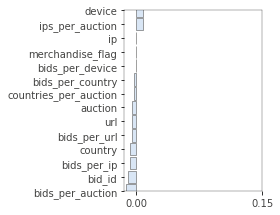

In [17]:
imp = importances(final_model, X_valid, y_valid, n_samples=-1)
viz = plot_importances(imp)
viz.view()

### 5-Fold Cross Validation

In [18]:
def k_fold_validation(n=5):
    f1_scores = []
    roc_auc_scores = []
    rebalance_instance = imblearn.over_sampling.SMOTE()
    for i in range(n):
        final_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, max_features=0.4, 
                                     criterion='entropy')
        X_train, X_test, y_train, y_test = class_balance_split(users_X, test_size=0.2)
        X_train_smote, y_train_smote = rebalance_instance.fit_sample(X_train, y_train)
        final_model.fit(X_train_smote, y_train_smote)
        y_pred = final_model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred,average='weighted'))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))

    print(f"f1_scores: {f1_scores}") 
    print(f"roc_auc_scores: {roc_auc_scores}") 

In [19]:
k_fold_validation()

f1_scores: [0.9392607881521832, 0.9358264756950219, 0.9328470140674513, 0.9375880384331903, 0.9435542674356965]
roc_auc_scores: [0.7409623535277985, 0.8257292445774121, 0.7145350286711544, 0.8270381451009724, 0.7223884318125156]


# Deliver

In [20]:
X = users_X
y = X['outcome']
X.pop('outcome')

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2008    0.0
2009    0.0
2010    0.0
2011    0.0
2012    0.0
Name: outcome, Length: 2013, dtype: float64

In [21]:
final_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, max_features=0.4,criterion='entropy')
X_smote, y_smote = rebalance_instance.fit_sample(X, y)
final_model.fit(X_smote, y_smote)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Conclusion

- RandomForestClassifier performed the best on the dataset
- Model predictions have a weighted f1_score of ~0.95 on the validation set

#### Take-aways

Our model is hard to interpret in terms of important features as the importance of the features seem to changes a lot with the final model chosen. Below listed are few parameters which consistently came out as the importance ones for the model
- Count of unique devices, ips and countries that the user have bid from
- Average number of bids made per device and ip

To be able to put this model into production, there should be 2-step verification process for the robots predicted as there are good number of Humans that are being predicted as Robots